In [12]:
import torch
import torch.nn.functional as F
from tqdm import tqdm
import matplotlib.pyplot as plt

import config as CFG
from models import ZINBencoder, CLIPModel
from dataset import CLIPDataset
import scanpy as sc
from torch.utils.data import DataLoader

import os
import numpy as np
import pandas as pd

import scanpy as sc
%matplotlib inline

In [13]:
def visualize_umap_clusters(expr_matrix, preprocess = True, normalize_and_log = True, batch_idx = None, n_neighbors=150, n_top_genes=1024, max_value=10, legend_loc='on data', show=False, save=False, save_name='umap_clusters.png'):
    #! scanpy input matrix has cells as rows and genes as columns, same as this function
    if preprocess:
        # # Filter out genes with expression in less than 50 spots (for a ~8000 spot dataset over 4 slices)
        # expressed = np.sum(expr_matrix>0, axis=0)
        # expr_matrix = expr_matrix[:,expressed>50]

        # Create AnnData object with batch index as an observation
        adata = sc.AnnData(X=expr_matrix, dtype=expr_matrix.dtype)
        if batch_idx is not None:
            adata.obs['batch_idx'] = batch_idx

        # Preprocess the data
        if normalize_and_log:
            sc.pp.normalize_total(adata)
            sc.pp.log1p(adata)
        sc.pp.highly_variable_genes(adata, n_top_genes=n_top_genes)
        print("n_top_genes: ", adata.var['highly_variable'].sum())
        # sc.pp.scale(adata, max_value=max_value)
    else:
        adata = sc.AnnData(X=expr_matrix, dtype=expr_matrix.dtype)
        if batch_idx is not None:
            adata.obs['batch_idx'] = batch_idx

    # Run UMAP and clustering on the preprocessed data
    # sc.pp.scale(adata, max_value=max_value)
    sc.pp.pca(adata, n_comps=50, use_highly_variable=preprocess)
    sc.pp.neighbors(adata, n_neighbors=n_neighbors, n_pcs=50)

    sc.tl.umap(adata)
    print("Running Leiden clustering")
    sc.tl.leiden(adata)
    print("n_clusters: ", adata.obs['leiden'].nunique())
    print("Plotting UMAP clusters")

    # Plot the UMAP embedding with cell clusters and batch index
    if batch_idx is None:
        fig, ax = plt.subplots(figsize=(6, 5))
        sc.pl.umap(adata, color='leiden', ax=ax, show=show, legend_loc=legend_loc)

        # Save the figure
        if save:
            fig.savefig(save_name, dpi=300, bbox_inches='tight')
        
        return adata

    else:
        fig, axs = plt.subplots(ncols=2, figsize=(10,5))

        # Plot the UMAP embedding with cell clusters
        sc.pl.umap(adata, color='leiden', ax=axs[0], show=False, legend_loc=legend_loc)

        # Plot the UMAP embedding with batch information
        sc.pl.umap(adata, color='batch_idx', ax=axs[1], show=False, legend_loc=legend_loc)


        # Save the figure
        if save:
            fig.savefig(save_name, dpi=300, bbox_inches='tight')

        return adata

In [14]:
class CLIPDataset(torch.utils.data.Dataset):
    def __init__(self, df):
        self.df = df

    def transform(self, image):
        image = Image.fromarray(image)
        # Random flipping and rotations
        if random.random() > 0.5:
            image = TF.hflip(image)
        if random.random() > 0.5:
            image = TF.vflip(image)
        angle = random.choice([180, 90, 0, -90])
        image = TF.rotate(image, angle)
        return np.asarray(image)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        id_ = row['id']
        patch_x = row['patch_x_obj']
        patch_y = row['patch_y_obj']

        index = self.df.iloc[idx]['bead']
        
        reduced_matrix = np.load("/raid/HEST-1K/071524_hvg_matrix/hvg_matrix_{0}.npy".format(id_)).T
        image_features = np.load('/raid/mpleasure/data_deepstorage/st_projects/visium/uni_20x_hest_patching_normalized//{0}/{1}_{2}.npy'.format(id_, patch_x, patch_y))
        item = {}
        item['image_features'] = torch.tensor(image_features).float() #color channel first, then XY
        item['reduced_expression'] = torch.tensor(reduced_matrix[index]).float()  #cell x features (3467)
        # print(idx, len(np.unique(reduced_matrix[index])))
        # item['barcode'] = barcode
        item['spatial_coords'] = [patch_x,patch_y]

        return item


    def __len__(self):
        return self.df.shape[0]


In [15]:
# import torch.nn as nn
# from modules import ImageEncoder, ProjectionHead, ImageEncoder_ViT, ImageEncoder_ViT_L, ImageEncoder_CLIP, ImageEncoder_resnet101, ImageEncoder_resnet152

# class CLIPModel(nn.Module):
#     def __init__(
#         self,
#         temperature=CFG.temperature,
#         image_embedding=CFG.image_embedding,
#         spot_embedding=CFG.spot_embedding,
#         spot_encoder=None,
#     ):
#         super().__init__()
#         # self.image_encoder = ImageEncoder()
#         self.spot_encoder = spot_encoder
#         self.image_projection = ProjectionHead(embedding_dim=image_embedding) #aka the input dim, 2048 for resnet50
#         self.spot_projection = ProjectionHead(embedding_dim=64) #3467 shared hvgs
#         self.temperature = temperature

#     def forward(self, batch):
#         # Getting Image and spot Features
#         image_features = batch["image_features"]
#         # spot_features = batch["reduced_expression"]
#         spot_features = self.spot_encoder(batch)
        
#         # Getting Image and Spot Embeddings (with same dimension) 
#         image_embeddings = self.image_projection(image_features)
#         spot_embeddings = self.spot_projection(spot_features)

#         # Calculating the Loss
#         logits = (spot_embeddings @ image_embeddings.T) / self.temperature
#         images_similarity = image_embeddings @ image_embeddings.T
#         spots_similarity = spot_embeddings @ spot_embeddings.T
#         targets = F.softmax(
#             (images_similarity + spots_similarity) / 2 * self.temperature, dim=-1
#         )
#         spots_loss = cross_entropy(logits, targets, reduction='none')
#         images_loss = cross_entropy(logits.T, targets.T, reduction='none')
#         loss =  (images_loss + spots_loss) / 2.0 # shape: (batch_size)
#         return loss.mean()

In [16]:
# enc = ZINBencoder().cuda()
# enc.load_state_dict(torch.load('/raid/eredekop/071024_ST/checkpoints/tmp_zinb_enc_ep0_loss_0.4284879542529419.pt'))
# enc.cuda()

model = CLIPModel().cuda()

model_path = '/raid/eredekop/071024_ST/checkpoints/0904_upd_norm_ep99_loss0.363960.pt'#tmp_ep48_loss0.5962008856537135.pt'
state_dict = torch.load(model_path)
new_state_dict = {}
for key in state_dict.keys():
    new_key = key.replace('module.', '')  # remove the prefix 'module.'
    new_key = new_key.replace('well', 'spot') # for compatibility with prior naming
    new_state_dict[new_key] = state_dict[key]

model.load_state_dict(new_state_dict)
model.eval()

CLIPModel(
  (image_projection): ProjectionHead(
    (projection): Linear(in_features=1024, out_features=256, bias=True)
    (gelu): GELU(approximate='none')
    (fc): Linear(in_features=256, out_features=256, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  )
  (spot_projection): ProjectionHead(
    (projection): Linear(in_features=7968, out_features=256, bias=True)
    (gelu): GELU(approximate='none')
    (fc): Linear(in_features=256, out_features=256, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  )
)

In [17]:
folds = np.load('/raid/eredekop/071024_ST/data/folds.npy', allow_pickle=True)
df = pd.read_csv('/raid/mpleasure/data_deepstorage/st_projects/visium/updated_coords_hest_patching.csv')
# df1 = pd.read_csv('/raid/mpleasure/data_deepstorage/st_projects/visium/all_coords_visium_data.csv')
# df = pd.merge(df1, df2, on=['id', 'patch_x', 'patch_y'], how='inner')

train_df = df[df['id'].isin(list(folds[0][0]))]
val_df = df[df['id'].isin(list(folds[0][1]))]
train_dataset = CLIPDataset(train_df)
val_dataset = CLIPDataset(val_df)

In [18]:
df.shape#, df1.shape

(1329882, 10)

In [19]:
train_loader = DataLoader(train_dataset, batch_size=512, shuffle=False, num_workers=16, sampler=None)
test_loader = DataLoader(val_dataset, batch_size=512, shuffle=False, num_workers=16, sampler=None)

In [20]:
image_embeddings_list = []
spot_embeddings_list = []
spot_expression_list = []
model.train(False)

with torch.no_grad():
    for i, batch in enumerate(tqdm(train_loader)):
        batch = {k: v.cuda() for k, v in batch.items() if k == "image_features" or k == "reduced_expression"}
        image_features = batch["image_features"].cuda()
#             image_features = model.model256.forward(batch["image"].cuda())
        image_embeddings = model.image_projection(image_features)
        spot_embeddings = model.spot_projection(batch["reduced_expression"].cuda())
        spot_expression_list.append(batch["reduced_expression"].cpu().detach().numpy())
#         print(image_embeddings.cpu().detach().numpy().shape)
        image_embeddings_list.append(image_embeddings.cpu().detach().numpy())
        spot_embeddings_list.append(spot_embeddings.cpu().detach().numpy())
#         np.save('/raid/HEST-1K/trained_BLEEP_data/image_embeddings/{0}.npy'.format(i), image_embeddings.cpu().detach().numpy())
#         np.save('/raid/HEST-1K/trained_BLEEP_data/spot_embeddings/{0}.npy'.format(i), spot_embeddings.cpu().detach().numpy())
#         test_image_embeddings.append(image_embeddings)

# test_image_embeddings = torch.cat(test_image_embeddings)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 770/770 [1:18:04<00:00,  6.08s/it]


In [21]:
image_embeddings_array = np.concatenate(image_embeddings_list, axis=0)
spot_embeddings_array = np.concatenate(spot_embeddings_list, axis=0)
spot_expression_list = np.concatenate(spot_expression_list, axis=0)
np.save('/raid/HEST-1K/trained_BLEEP_data/0904_image_embeddings_enc_redo_normalized_ep99_train.npy', image_embeddings_array)
np.save('/raid/HEST-1K/trained_BLEEP_data/0904_spot_embeddings_enc_redo_normalized_ep99_train.npy', spot_embeddings_array)
np.save('/raid/HEST-1K/trained_BLEEP_data/spot_expression.npy', spot_expression_list)

In [22]:
hest_data_root = '/raid/HEST-1K'
hest_csv = pd.read_csv(os.path.join(hest_data_root, 'HEST_v1_0_0.csv'), index_col = 0)
visium_only = hest_csv[hest_csv['st_technology'] == 'Visium']
visium_only_not_brain = visium_only[visium_only['organ']!='Brain']
visium_only_not_brain = visium_only_not_brain[visium_only_not_brain['organ']!='Embryo']
visium_only_not_brain = visium_only_not_brain[visium_only_not_brain['organ']!='Lung/Brain']
visium_only_not_brain = visium_only_not_brain[visium_only_not_brain['organ']!='Kidney/Brain']
# visium_only_not_brain = visium_only_not_brain[visium_only_not_brain['organ']!='nan']
visium_only_not_brain = visium_only_not_brain[visium_only_not_brain['species'] == 'Homo sapiens']
visium_only_not_brain = visium_only_not_brain[visium_only_not_brain['nb_genes'] > 10000]
visium_only_not_brain = visium_only_not_brain[visium_only_not_brain['id'] !='INT17']
visium_only_not_brain[visium_only_not_brain['id'] == 'NCBI463']


,id,image_filename,organ,disease_state,oncotree_code,species,patient,st_technology,data_publication_date,license,...,nb_genes,treatment_comment,pixel_size_um_embedded,pixel_size_um_estimated,magnification,fullres_px_width,fullres_px_height,tissue,disease_comment,subseries
dataset_title,,,,,,,,,,,,,,,,,,,,,
Spatial transcriptomics landscape of non-communicable inflammatory skin diseases,NCBI463,NCBI463.tif,Skin,Diseased,NaN,Homo sapiens,NaN,Visium,"November 14, 2022",CC BY 4.0,...,20613,NaN,NaN,1.055517,10x,8182,8192,Skin,psoriasis lesional,"Patient 31, 32 lesional psoriasis, rep 2 [21L0..."


In [23]:
val_df['id'].unique()

array(['TENX71', 'TENX70', 'TENX65', 'TENX49', 'TENX40', 'TENX39',
       'TENX15', 'ZEN47', 'ZEN46', 'ZEN44', 'ZEN40', 'ZEN39', 'ZEN37',
       'INT35', 'INT28', 'INT24', 'INT23', 'INT19', 'INT12', 'INT11',
       'INT10', 'INT6', 'INT2', 'MEND161', 'MEND160', 'MEND158',
       'MEND157', 'MEND148', 'MEND143', 'MEND142', 'MEND91', 'MEND88',
       'MEND86', 'MEND85', 'MEND60', 'MEND59', 'MEND54', 'MEND49',
       'MEND48', 'MEND39', 'MEND38', 'MEND37', 'MEND33', 'NCBI855',
       'NCBI854', 'NCBI828', 'NCBI827', 'NCBI776', 'NCBI771', 'NCBI714',
       'NCBI712', 'NCBI709', 'NCBI705', 'NCBI703', 'NCBI700', 'NCBI696',
       'NCBI691', 'NCBI682', 'NCBI674', 'NCBI643', 'NCBI592', 'NCBI570',
       'NCBI567', 'NCBI562', 'NCBI537', 'NCBI535', 'NCBI526', 'NCBI521',
       'NCBI510', 'NCBI505', 'NCBI504', 'NCBI496', 'NCBI494', 'NCBI492',
       'NCBI491', 'NCBI486', 'NCBI483', 'NCBI481', 'NCBI476', 'NCBI470',
       'NCBI468', 'NCBI467', 'NCBI465', 'NCBI463', 'NCBI1', 'MISC32',
       'MISC2

In [24]:

val_df_id = val_df[val_df['id'] == 'NCBI463']
val_dataset = CLIPDataset(val_df_id)
test_loader = DataLoader(val_dataset, batch_size=512, shuffle=False, num_workers=16, sampler=None)

In [25]:
val_df1 = df[df['id'].isin(list(folds[0][1]))]
val_df_id1 = val_df1[val_df1['id'] == 'NCBI463']

In [26]:
val_df_id1['bead']

1214415       0
1214416       1
1214417       2
1214418       3
1214419       4
           ... 
1215663    1248
1215664    1249
1215665    1250
1215666    1251
1215667    1252
Name: bead, Length: 1253, dtype: int64

In [27]:
val_df_id

,Unnamed: 0,index,id,bead,patch_x,patch_y,bead_center_x,bead_center_y,patch_x_obj,patch_y_obj
1214415,1214930,1214930,NCBI463,0,5767,4770,5879.840638,4882.920089,5826,4829
1214416,1214931,1214931,NCBI463,1,1840,5529,1952.556762,5641.809536,1899,5588
1214417,1214932,1214932,NCBI463,2,1550,4540,1662.461962,4652.232416,1609,4599
1214418,1214933,1214933,NCBI463,3,6381,4355,6493.199258,4467.636833,6440,4414
1214419,1214934,1214934,NCBI463,4,2258,4124,2370.560124,4236.567295,2317,4183
...,...,...,...,...,...,...,...,...,...,...
1215663,1216178,1216178,NCBI463,1248,3731,4861,3843.430160,4973.690419,3790,4920
1215664,1216179,1216179,NCBI463,1249,4574,3207,4686.292419,3319.049105,4633,3266
1215665,1216180,1216180,NCBI463,1250,2929,5442,3041.571817,5554.857859,2988,5501
1215666,1216181,1216181,NCBI463,1251,2362,5610,2474.113926,5722.269503,2421,5669


In [28]:
absent_beads = []
for item in np.array(val_df_id1['bead']):
    if item not in np.array(val_df_id['bead']):
        absent_beads.append(item)
absent_beads

[]

In [29]:
image_embeddings_list = []
spot_embeddings_list = []
spot_expressions_list = []
expression_gt = []
with torch.no_grad():
    for i, batch in enumerate(tqdm(test_loader)):
        image_features = batch["image_features"].cuda()
        expression_gt.append(batch["reduced_expression"].numpy())
#             image_features = model.model256.forward(batch["image"].cuda())
        image_embeddings = model.image_projection(image_features)
#         spot_embeddings = model.spot_projection(batch["reduced_expression"].cuda())
#         print(image_embeddings.cpu().detach().numpy().shape)
        image_embeddings_list.append(image_embeddings.cpu().detach().numpy())
#         spot_embeddings_list.append(spot_embeddings.cpu().detach().numpy())
image_query = np.concatenate(image_embeddings_list, axis=0)
expression_gt = np.concatenate(expression_gt, axis=0)
expression_gt.shape
# spot_embeddings_array = np.concatenate(spot_embeddings_list, axis=0)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:18<00:00,  6.25s/it]


(1253, 7968)

In [30]:
def find_matches(spot_embeddings, query_embeddings, top_k=1):
    #find the closest matches 
    spot_embeddings = torch.tensor(spot_embeddings)
    query_embeddings = torch.tensor(query_embeddings)
    query_embeddings = F.normalize(query_embeddings, p=2, dim=-1)
    spot_embeddings = F.normalize(spot_embeddings, p=2, dim=-1)
    dot_similarity = query_embeddings @ spot_embeddings.T   #2277x2265
#     print(dot_similarity.shape)
    _, indices = torch.topk(dot_similarity.squeeze(0), k=top_k)
    
    return indices.cpu().numpy()

In [31]:
spot_key = np.load('/raid/HEST-1K/trained_BLEEP_data/0904_image_embeddings_enc_redo_normalized_ep99_train.npy')
expression_key = np.load('/raid/HEST-1K/trained_BLEEP_data/spot_expression.npy')

In [32]:
print("finding matches, using average of top 50 expressions")
indices = find_matches(spot_key, image_query, top_k=50)


finding matches, using average of top 50 expressions
torch.Size([1253, 394147])


In [33]:
matched_spot_embeddings_pred = np.zeros((indices.shape[0], spot_key.shape[1]))
matched_spot_expression_pred = np.zeros((indices.shape[0], expression_key.shape[1]))
for i in range(indices.shape[0]):
    matched_spot_embeddings_pred[i,:] = np.average(spot_key[indices[i,:],:], axis=0)
    matched_spot_expression_pred[i,:] = np.average(expression_key[indices[i,:],:], axis=0)

print("matched spot embeddings pred shape: ", matched_spot_embeddings_pred.shape)
print("matched spot expression pred shape: ", matched_spot_expression_pred.shape)

matched spot embeddings pred shape:  (1253, 256)
matched spot expression pred shape:  (1253, 7968)


In [34]:
true = expression_gt
pred = matched_spot_expression_pred

print(pred.shape)
print(true.shape)
print(np.max(pred))
print(np.max(true))
print(np.min(pred))
print(np.min(true))

#genewise correlation
corr = np.zeros(pred.shape[0])
for i in range(pred.shape[0]):
    corr[i] = np.corrcoef(pred[i,:], true[i,:],)[0,1] #corrcoef returns a matrix
#remove nan
corr = corr[~np.isnan(corr)]
print("Mean correlation across cells: ", np.mean(corr))

corr = np.zeros(pred.shape[1])
for i in range(pred.shape[1]):
    corr[i] = np.corrcoef(pred[:,i], true[:,i],)[0,1] #corrcoef returns a matrix
#remove nan
corr = corr[~np.isnan(corr)]
print("number of non-zero genes: ", corr.shape[0])
print("mean correlation: ", np.mean(corr))
print("max correlation: ", np.max(corr))
print("number of genes with correlation > 0.3: ", np.sum(corr > 0.3))

# if save_path != "":
#     np.save(save_path + "matched_spot_embeddings_pred.npy", matched_spot_embeddings_pred.T)
#     np.save(save_path + "matched_spot_expression_pred.npy", matched_spot_expression_pred.T)

(1253, 7968)
(1253, 7968)
3764.179931640625
11038.0
0.0
0.0
Mean correlation across cells:  0.8430540390734925


/raid/eredekop/anaconda3/envs/py39/lib/python3.7/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/raid/eredekop/anaconda3/envs/py39/lib/python3.7/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


number of non-zero genes:  6416
mean correlation:  0.43311373211235726
max correlation:  0.8917601433756746
number of genes with correlation > 0.3:  4337


In [35]:
corr.shape, pred.shape, true.shape

((6416,), (1253, 7968), (1253, 7968))

In [36]:
import scanpy as sc
# Create an AnnData object from the gene expression data
adata = sc.AnnData(true)

# Preprocess the data (you can adjust the steps based on your data)
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

# Perform PCA for dimensionality reduction
sc.pp.pca(adata, n_comps=50, use_highly_variable=False)
sc.pp.neighbors(adata, n_neighbors=150, n_pcs=50)
sc.tl.umap(adata)
sc.tl.leiden(adata)

# Access cluster assignments for each spot
cluster_assignments = adata.obs['leiden']

# Print cluster assignments
print(cluster_assignments)

0       1
1       0
2       0
3       1
4       0
       ..
1248    2
1249    2
1250    0
1251    0
1252    0
Name: leiden, Length: 1253, dtype: category
Categories (7, object): ['0', '1', '2', '3', '4', '5', '6']


In [37]:
# leiden_clusters, spatial_coords.shape

In [38]:
id_ = 'NCBI463'
d = '/raid/HEST-1K/st/{0}.h5ad'.format(id_)
adata = sc.read_h5ad(d)

In [39]:
im = adata.uns["spatial"]["ST"]["images"]["downscaled_fullres"] 
scalef = adata.uns["spatial"]["ST"]["scalefactors"]["tissue_downscaled_fullres_scalef"] 

In [40]:
spatial_coords = adata.obsm['spatial']
filtered_spatial_coords = np.delete(spatial_coords, absent_beads, axis=0).reshape((spatial_coords.shape[0]-len(absent_beads), 2))

In [41]:
filtered_spatial_coords.shape

(1253, 2)

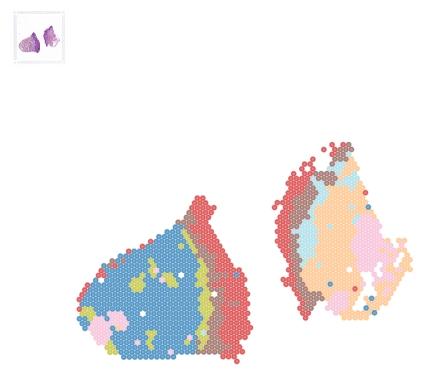

In [42]:
import matplotlib.pyplot as plt
import scanpy as sc

# Assuming adata is your AnnData object

# Extract spatial coordinates (if stored in obsm)


# Extract leiden clusters
leiden_clusters = cluster_assignments #adata.obs['leiden']

# Load the spatial image
spatial_image = adata.uns["spatial"]["ST"]["images"]["downscaled_fullres"]

# Plot the image
plt.imshow(spatial_image)

# Overlay the clusters on the image
# Assuming spatial_coords has the format (x, y)
plt.scatter(filtered_spatial_coords[:, 0], filtered_spatial_coords[:, 1], c=leiden_clusters.astype(float), cmap='tab20', s=10, alpha=0.6)

# Show the plot
plt.axis('off')
plt.show()


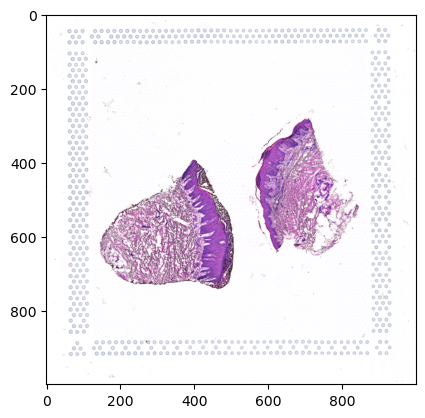

In [43]:
plt.imshow(spatial_image)

In [44]:
import scanpy as sc
# Create an AnnData object from the gene expression data
adata = sc.AnnData(pred)

# Preprocess the data (you can adjust the steps based on your data)
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

# Perform PCA for dimensionality reduction
sc.pp.pca(adata, n_comps=50, use_highly_variable=False)
sc.pp.neighbors(adata, n_neighbors=150, n_pcs=50)
sc.tl.umap(adata)
sc.tl.leiden(adata)

# Access cluster assignments for each spot
cluster_assignments = adata.obs['leiden']

# Print cluster assignments
print(cluster_assignments)

/raid/eredekop/anaconda3/envs/py39/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  This is separate from the ipykernel package so we can avoid doing imports until


0       1
1       0
2       0
3       1
4       0
       ..
1248    7
1249    5
1250    0
1251    0
1252    0
Name: leiden, Length: 1253, dtype: category
Categories (9, object): ['0', '1', '2', '3', ..., '5', '6', '7', '8']


In [45]:
id_ = 'NCBI463'
d = '/raid/HEST-1K/st/{0}.h5ad'.format(id_)
adata = sc.read_h5ad(d)

In [ ]:
import matplotlib.pyplot as plt
import scanpy as sc

# Assuming adata is your AnnData object

# Extract spatial coordinates (if stored in obsm)
spatial_coords = adata.obsm['spatial']

# Extract leiden clusters
leiden_clusters = cluster_assignments #adata.obs['leiden']

# Load the spatial image
spatial_image = adata.uns["spatial"]["ST"]["images"]["downscaled_fullres"]

# Plot the image
plt.imshow(spatial_image)

# Overlay the clusters on the image
# Assuming spatial_coords has the format (x, y)
plt.scatter(filtered_spatial_coords[:, 0], filtered_spatial_coords[:, 1], c=leiden_clusters.astype(float), cmap='tab20', s=10, alpha=0.6)

# Show the plot
plt.axis('off')
plt.show()


In [47]:
df = pd.read_csv('/raid/zichenwang/data/deep_storage/CPIA_Full/CPIA_patch/Patch_Path/M/TCGA-PRAD-384.csv')

In [49]:
if len(df) > 1_200_000:
    # Randomly sample 1.2 million rows without replacement
    df = df.sample(n=1_200_000, random_state=42)

# Display the first few rows of the subsampled DataFrame
print(df.head())

                                      filename
486830   TCGA-WW-A8ZI-01Z-00-DX6-384-28-28.jpg
2040193  TCGA-HC-A6AP-01Z-00-DX1-384-25-46.jpg
1979996  TCGA-EJ-5498-01Z-00-DX1-384-63-37.jpg
1290325  TCGA-EJ-5522-01Z-00-DX1-384-43-64.jpg
1390101  TCGA-EJ-5525-01Z-00-DX1-384-24-42.jpg


In [50]:
df.shape

(1200000, 1)